In [53]:
from SEMPIDataLoader import InterPersenSEMPIDataset, DataSetLoader, DataLoader
from SEMPIDataLoader import create_dataloaders
from SEMPIDataLoader import DATA_PATH

import torch
import os
import numpy as np
import pandas as pd
import pickle


import torch.nn as nn
import torch.optim as optim

import sklearn

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


import matplotlib.pyplot as plt

In [54]:
print("Installed PyTorch version:", torch.__version__)
print("PyTorch built with CUDA:", torch.backends.cudnn.is_available())  # Should return True if CUDA is enabled

print("PyTorch CUDA Available:", torch.cuda.is_available())  # Should return True
print("CUDA Version in PyTorch:", torch.version.cuda)  # Should return '12.8' or similar
print("Available GPUs:", torch.cuda.device_count())  # Should be >0 if GPU exists
print("GPU Name:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No GPU detected")

Installed PyTorch version: 2.5.1+cu121
PyTorch built with CUDA: True
PyTorch CUDA Available: True
CUDA Version in PyTorch: 12.1
Available GPUs: 1
GPU Name: NVIDIA GeForce RTX 2060


In [55]:
# load the dataset and dataloaders with pickle
with open(os.path.join(DATA_PATH, 'dataset.pkl'), 'rb') as f:
    dataset: InterPersenSEMPIDataset = pickle.load(f)

train_loader, val_loader = create_dataloaders(dataset, batch_size=32)
print(len(train_loader), len(val_loader))
print(len(dataset))
print("Data loaded successfully!")
print(f"Train size: {len(train_loader.dataset)}")
print(f"Val size: {len(val_loader.dataset)}")

for i, data in enumerate(train_loader):
    print(f"Batch {i}")
    if i == 2:
        break
    print(data['features'].shape)
    print(data['pids'])
    print(data['score'])


382 96
15256
Data loaded successfully!
Train size: 12204
Val size: 3052
Batch 0
torch.Size([32, 2, 329, 64])
tensor([[3, 7],
        [5, 2],
        [3, 8],
        [4, 6],
        [3, 5],
        [6, 7],
        [2, 3],
        [3, 1],
        [2, 1],
        [6, 5],
        [4, 1],
        [2, 3],
        [4, 1],
        [1, 4],
        [6, 7],
        [1, 2],
        [3, 2],
        [1, 7],
        [1, 2],
        [6, 4],
        [3, 1],
        [2, 1],
        [4, 1],
        [1, 7],
        [1, 3],
        [4, 5],
        [6, 1],
        [4, 1],
        [1, 2],
        [4, 8],
        [5, 4],
        [4, 8]], dtype=torch.int32)
tensor([ 3.3333e-02, -2.1667e-01,  1.6667e-01, -3.3333e-02,  1.8333e-01,
         1.1667e-01, -5.0000e-02, -1.1667e-01, -2.7756e-17,  1.1667e-01,
         8.3333e-02, -2.7756e-17,  3.3333e-02,  1.3333e-01, -5.0000e-02,
         1.1667e-01, -6.6667e-02,  1.1667e-01,  0.0000e+00,  1.0000e-01,
         5.0000e-02, -1.6667e-02,  1.0000e-01,  8.3333e-02, -5.0000

In [56]:
# Function to train the model
def train(model, num_epochs, train_loader, criterion, optimizer, scheduler):

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    # Enable GPU optimization if available (to speed up training)
    if device.type == "cuda":
        torch.backends.cudnn.benchmark = True 

    losses = []
    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
    
        for batch in train_loader:
            features, scores = batch['features'].to(device), batch['score'].to(device)

            # Forward pass
            outputs = model(features).squeeze()

            # Compute loss
            loss = criterion(outputs, scores)
            total_loss += loss.item()

            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        # Adjust learning rate
        scheduler.step()
        losses.append(total_loss / len(train_loader))
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss / len(train_loader):.4f}, LR: {scheduler.get_last_lr()[0]:.6f}")

    return losses

In [57]:
class RNNModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout=0.3):
        super(RNNModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        # Two separate RNNs for the two individuals
        self.rnn1 = nn.RNN(input_size, hidden_size, num_layers, batch_first=True, nonlinearity='relu', dropout=dropout)
        self.rnn2 = nn.RNN(input_size, hidden_size, num_layers, batch_first=True, nonlinearity='relu', dropout=dropout)

        # Fully connected layer after merging outputs
        self.fc = nn.Linear(hidden_size * 2, output_size)

    def forward(self, x):
        # Split the input into two separate individuals
        x1, x2 = x[:, 0, :, :], x[:, 1, :, :]  # Each becomes (batch_size, 329, 64)

        # Initialize hidden states
        h0_1 = torch.zeros(self.num_layers, x1.size(0), self.hidden_size).to(x.device)
        h0_2 = torch.zeros(self.num_layers, x2.size(0), self.hidden_size).to(x.device)

        # Process both individuals separately
        out1, _ = self.rnn1(x1, h0_1)
        out2, _ = self.rnn2(x2, h0_2)

        # Take the output from the last time step of each individual
        out1 = out1[:, -1, :]  # Shape: (batch_size, hidden_size)
        out2 = out2[:, -1, :]  # Shape: (batch_size, hidden_size)

        # Concatenate both outputs
        out = torch.cat((out1, out2), dim=1)  # Shape: (batch_size, hidden_size * 2)

        # Fully connected layer for final prediction
        out = self.fc(out)
        return out

In [58]:
def evaluate_model(model, val_loader):
    model.eval()
    predictions_list = []
    actual_list = []

    with torch.no_grad():
        for batch in val_loader:
            features, scores = batch['features'].to(device), batch['score'].to(device)

            # Forward pass
            predictions = model(features).squeeze()

            predictions_list.extend(predictions.cpu().numpy())
            actual_list.extend(scores.cpu().numpy())

    # Convert to NumPy arrays for metric calculations
    predictions_list = np.array(predictions_list)
    actual_list = np.array(actual_list)

    # Compute evaluation metrics
    mse = mean_squared_error(actual_list, predictions_list)
    mae = mean_absolute_error(actual_list, predictions_list)
    r2 = r2_score(actual_list, predictions_list)

    print(f"Validation Metrics:\n"
          f"  - MSE  = {mse:.4f}\n"
          f"  - MAE  = {mae:.4f}\n"
          f"  - R²   = {r2:.4f}")

    return mse, mae, r2


In [59]:
# Model parameters
input_size = 64       # Features per timestep
hidden_size = 128     # Hidden units in LSTM
num_layers = 2        # LSTM layers
output_size = 1       # Predicting a single score


# Epochs for training
num_epochs = 20


# Define loss function (Huber loss is more robust to outliers)
criterion = nn.SmoothL1Loss()  


# Initialize model
rnn_model = RNNModel(input_size, hidden_size, num_layers, output_size)

# Adam optimizer
optimizer = optim.Adam(rnn_model.parameters(), lr=0.001)

# Learning rate scheduler to reduce LR by half every 3 epochs
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.5)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
rnn_model.to(device)


RNNModel(
  (rnn1): RNN(64, 128, num_layers=2, batch_first=True, dropout=0.3)
  (rnn2): RNN(64, 128, num_layers=2, batch_first=True, dropout=0.3)
  (fc): Linear(in_features=256, out_features=1, bias=True)
)

In [60]:
# Train RNN
rnn_losses = train(rnn_model, num_epochs, train_loader, criterion, optimizer, scheduler)

Using device: cuda
Epoch [1/20], Loss: 0.0097, LR: 0.001000
Epoch [2/20], Loss: 0.0088, LR: 0.001000
Epoch [3/20], Loss: 0.0074, LR: 0.000500
Epoch [4/20], Loss: 0.0055, LR: 0.000500
Epoch [5/20], Loss: 0.0044, LR: 0.000500
Epoch [6/20], Loss: 0.0036, LR: 0.000250
Epoch [7/20], Loss: 0.0027, LR: 0.000250
Epoch [8/20], Loss: 0.0025, LR: 0.000250
Epoch [9/20], Loss: 0.0022, LR: 0.000125
Epoch [10/20], Loss: 0.0019, LR: 0.000125
Epoch [11/20], Loss: 0.0017, LR: 0.000125
Epoch [12/20], Loss: 0.0016, LR: 0.000063
Epoch [13/20], Loss: 0.0015, LR: 0.000063
Epoch [14/20], Loss: 0.0014, LR: 0.000063
Epoch [15/20], Loss: 0.0014, LR: 0.000031
Epoch [16/20], Loss: 0.0013, LR: 0.000031
Epoch [17/20], Loss: 0.0013, LR: 0.000031
Epoch [18/20], Loss: 0.0013, LR: 0.000016
Epoch [19/20], Loss: 0.0012, LR: 0.000016
Epoch [20/20], Loss: 0.0012, LR: 0.000016


In [73]:
print("Evaluating RNN...")
rnn_res = evaluate_model(rnn_model, val_loader)

Evaluating RNN...
Validation Metrics:
  - MSE  = 0.0048
  - MAE  = 0.0460
  - R²   = 0.7630


In [62]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout=0.3):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        # Two separate LSTMs for each individual
        self.lstm1 = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
        self.lstm2 = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)

        # Fully connected layer after merging outputs
        self.fc = nn.Linear(hidden_size * 2, output_size)

    def forward(self, x):
        # Split the input into two separate individuals
        x1, x2 = x[:, 0, :, :], x[:, 1, :, :]  # Each becomes (batch_size, 329, 64)

        # Initialize hidden and cell states
        h0_1 = torch.zeros(self.num_layers, x1.size(0), self.hidden_size).to(x.device)
        c0_1 = torch.zeros(self.num_layers, x1.size(0), self.hidden_size).to(x.device)

        h0_2 = torch.zeros(self.num_layers, x2.size(0), self.hidden_size).to(x.device)
        c0_2 = torch.zeros(self.num_layers, x2.size(0), self.hidden_size).to(x.device)

        # Process both individuals separately
        out1, _ = self.lstm1(x1, (h0_1, c0_1))
        out2, _ = self.lstm2(x2, (h0_2, c0_2))

        # Take the output from the last time step of each individual
        out1 = out1[:, -1, :]  # Shape: (batch_size, hidden_size)
        out2 = out2[:, -1, :]  # Shape: (batch_size, hidden_size)

        # Concatenate both outputs
        out = torch.cat((out1, out2), dim=1)  # Shape: (batch_size, hidden_size * 2)

        # Fully connected layer for final prediction
        out = self.fc(out)
        return out



In [63]:
# Model parameters
input_size = 64       # Features per timestep
hidden_size = 128     # Hidden units in LSTM
num_layers = 2        # LSTM layers
output_size = 1       # Predicting a single score


# Initialize model
lstm_model = LSTMModel(input_size, hidden_size, num_layers, output_size)

# Define loss function (Huber loss is more robust to outliers)
criterion = nn.SmoothL1Loss()  

# Adam optimizer
optimizer = optim.Adam(lstm_model.parameters(), lr=0.001)

# Learning rate scheduler to reduce LR by half every 3 epochs
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.5)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
lstm_model.to(device)

LSTMModel(
  (lstm1): LSTM(64, 128, num_layers=2, batch_first=True, dropout=0.3)
  (lstm2): LSTM(64, 128, num_layers=2, batch_first=True, dropout=0.3)
  (fc): Linear(in_features=256, out_features=1, bias=True)
)

In [64]:
lstm_losses = train(lstm_model, num_epochs, train_loader, criterion, optimizer, scheduler)

Using device: cuda
Epoch [1/20], Loss: 0.0095, LR: 0.001000
Epoch [2/20], Loss: 0.0091, LR: 0.001000
Epoch [3/20], Loss: 0.0085, LR: 0.000500
Epoch [4/20], Loss: 0.0074, LR: 0.000500
Epoch [5/20], Loss: 0.0066, LR: 0.000500
Epoch [6/20], Loss: 0.0059, LR: 0.000250
Epoch [7/20], Loss: 0.0050, LR: 0.000250
Epoch [8/20], Loss: 0.0045, LR: 0.000250
Epoch [9/20], Loss: 0.0041, LR: 0.000125
Epoch [10/20], Loss: 0.0037, LR: 0.000125
Epoch [11/20], Loss: 0.0034, LR: 0.000125
Epoch [12/20], Loss: 0.0032, LR: 0.000063
Epoch [13/20], Loss: 0.0030, LR: 0.000063
Epoch [14/20], Loss: 0.0029, LR: 0.000063
Epoch [15/20], Loss: 0.0028, LR: 0.000031
Epoch [16/20], Loss: 0.0027, LR: 0.000031
Epoch [17/20], Loss: 0.0027, LR: 0.000031
Epoch [18/20], Loss: 0.0026, LR: 0.000016
Epoch [19/20], Loss: 0.0026, LR: 0.000016
Epoch [20/20], Loss: 0.0025, LR: 0.000016


In [72]:
print("\nEvaluating LSTM...")
lstm_res = evaluate_model(lstm_model, val_loader)


Evaluating LSTM...
Validation Metrics:
  - MSE  = 0.0077
  - MAE  = 0.0650
  - R²   = 0.6161


In [66]:
class GRUModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout=0.3):
        super(GRUModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        # Two separate GRUs for each individual
        self.gru1 = nn.GRU(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
        self.gru2 = nn.GRU(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)

        # Fully connected layer after merging outputs
        self.fc = nn.Linear(hidden_size * 2, output_size)

    def forward(self, x):
        # Split the input into two separate individuals
        x1, x2 = x[:, 0, :, :], x[:, 1, :, :]  # Each becomes (batch_size, 329, 64)

        # Initialize hidden states
        h0_1 = torch.zeros(self.num_layers, x1.size(0), self.hidden_size).to(x.device)
        h0_2 = torch.zeros(self.num_layers, x2.size(0), self.hidden_size).to(x.device)

        # Process both individuals separately
        out1, _ = self.gru1(x1, h0_1)
        out2, _ = self.gru2(x2, h0_2)

        # Take the output from the last time step of each individual
        out1 = out1[:, -1, :]  # Shape: (batch_size, hidden_size)
        out2 = out2[:, -1, :]  # Shape: (batch_size, hidden_size)

        # Concatenate both outputs
        out = torch.cat((out1, out2), dim=1)  # Shape: (batch_size, hidden_size * 2)

        # Fully connected layer for final prediction
        out = self.fc(out)
        return out


In [67]:
# Initialize the GRU model
hidden_size = 128  
num_layers = 2  
output_size = 1  
gru_model = GRUModel(input_size=64, hidden_size=hidden_size, num_layers=num_layers, output_size=output_size).to(device)

# Define optimizer, loss, and scheduler
optimizer = torch.optim.Adam(gru_model.parameters(), lr=0.001)
criterion = nn.SmoothL1Loss()  # Huber loss
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.5)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
gru_model.to(device)

GRUModel(
  (gru1): GRU(64, 128, num_layers=2, batch_first=True, dropout=0.3)
  (gru2): GRU(64, 128, num_layers=2, batch_first=True, dropout=0.3)
  (fc): Linear(in_features=256, out_features=1, bias=True)
)

In [68]:
gru_losses = train(gru_model, num_epochs, train_loader, criterion, optimizer, scheduler)

Using device: cuda
Epoch [1/20], Loss: 0.0098, LR: 0.001000
Epoch [2/20], Loss: 0.0091, LR: 0.001000
Epoch [3/20], Loss: 0.0086, LR: 0.000500
Epoch [4/20], Loss: 0.0074, LR: 0.000500
Epoch [5/20], Loss: 0.0066, LR: 0.000500
Epoch [6/20], Loss: 0.0059, LR: 0.000250
Epoch [7/20], Loss: 0.0050, LR: 0.000250
Epoch [8/20], Loss: 0.0046, LR: 0.000250
Epoch [9/20], Loss: 0.0042, LR: 0.000125
Epoch [10/20], Loss: 0.0037, LR: 0.000125
Epoch [11/20], Loss: 0.0035, LR: 0.000125
Epoch [12/20], Loss: 0.0033, LR: 0.000063
Epoch [13/20], Loss: 0.0030, LR: 0.000063
Epoch [14/20], Loss: 0.0029, LR: 0.000063
Epoch [15/20], Loss: 0.0028, LR: 0.000031
Epoch [16/20], Loss: 0.0027, LR: 0.000031
Epoch [17/20], Loss: 0.0027, LR: 0.000031
Epoch [18/20], Loss: 0.0026, LR: 0.000016
Epoch [19/20], Loss: 0.0025, LR: 0.000016
Epoch [20/20], Loss: 0.0025, LR: 0.000016


In [71]:
print("Evaluating GRU Model...")
gru_res = evaluate_model(gru_model, val_loader)

Evaluating GRU Model...
Validation Metrics:
  - MSE  = 0.0078
  - MAE  = 0.0647
  - R²   = 0.6153


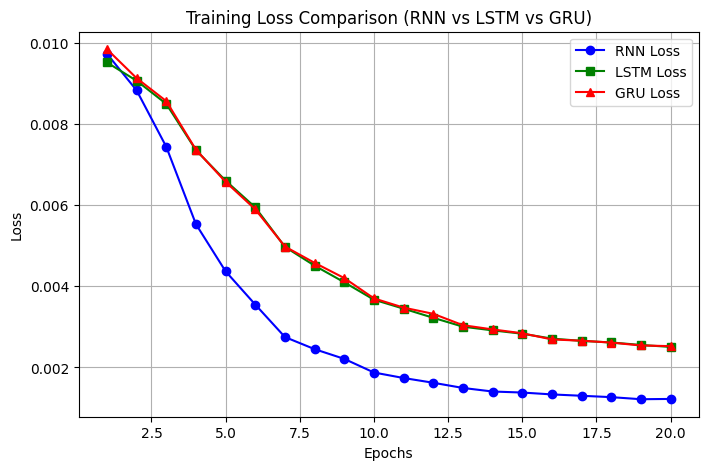

In [70]:
# Plot training loss
plt.figure(figsize=(8, 5))

plt.plot(range(1, num_epochs + 1), rnn_losses, marker='o', linestyle='-', color='blue', label="RNN Loss")
plt.plot(range(1, num_epochs + 1), lstm_losses, marker='s', linestyle='-', color='green', label="LSTM Loss")
plt.plot(range(1, num_epochs + 1), gru_losses, marker='^', linestyle='-', color='red', label="GRU Loss")

plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Loss Comparison (RNN vs LSTM vs GRU)")
plt.legend()
plt.grid()
plt.show()

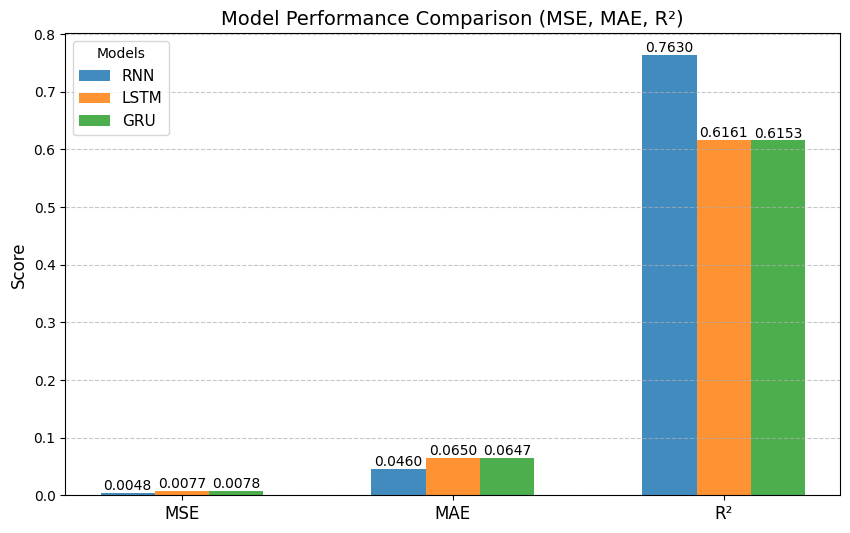

In [81]:
# Bar graphs for MSE, MAE, R2
metrics = ["MSE", "MAE", "R²"]
models = ["RNN", "LSTM", "GRU"]


values = np.array([rnn_res, lstm_res, gru_res])

ar_width = 0.2
x = np.arange(len(metrics))

fig, axis = plt.subplots(figsize=(10, 6))


for i, model in enumerate(models):
    bars = axis.bar(x + i * bar_width - bar_width, values[i], width=bar_width, label=model, alpha=0.85)

    for bar in bars:
        height = bar.get_height()
        axis.text(bar.get_x() + bar.get_width() / 2, height, f'{height:.4f}', ha='center', va='bottom', fontsize=10)

axis.set_xticks(x)
axis.set_xticklabels(metrics, fontsize=12)
axis.set_ylabel("Score", fontsize=12)
axis.set_title("Model Performance Comparison (MSE, MAE, R²)", fontsize=14)
axis.legend(title="Models", fontsize=11)
axis.grid(axis="y", linestyle="--", alpha=0.7)

# Show the updated plot
plt.show()